<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/FINAL-MODEL-NLP/unified_eye_disease_detection_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unified Eye Disease Detection Model
This notebook implements a machine learning pipeline to predict one of six eye diseases based on symptom datasets.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load, Merge, Clean, and Save the Dataset.

In [2]:
import pandas as pd

# Define dataset paths and labels
datasets = {
    "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/preprocessed_glaucoma_dataset.csv": "Glaucoma",
    "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_Cataract_Dataset.csv": "Cataract",
    "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_Diabetic_Retinopathy_Dataset.csv": "Diabetic Retinopathy",
    "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_CNV_Detection_Dataset.csv": "CNV",
    "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_DME_Dataset.csv": "DME",
    "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_Drusen_Dataset.csv": "Drusen"
}


# Step 1: Load datasets into a list
dataframes = []
for file, disease in datasets.items():
    try:
        df = pd.read_csv(file)
        print(f"Loaded dataset: {file} | Shape: {df.shape}")
        df["Disease_Label"] = disease  # Add disease label column
        dataframes.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Step 2: Merge all datasets while keeping all columns
merged_df = pd.concat(dataframes, ignore_index=True, sort=False)  # Keeps unique columns
print(f"\nMerged dataset shape (before cleaning): {merged_df.shape}")

# -----------------------------------------
# Step 3: Handling missing values
# -----------------------------------------

# Check for missing values before handling
print("\nMissing values before handling:\n", merged_df.isnull().sum())

# 🔹 Essential Disease-Specific Features (Ensure They Are Kept)
essential_features = [
    "Intraocular Pressure (IOP)", "Cup-to-Disc Ratio (CDR)", "Pachymetry",
    "Retinal Thickness", 'History of Diabetes',
    "Microaneurysms Count", "Hemorrhages Count", "BMI", "Blood Pressure",
    "Cholesterol Levels"
]

# 🔹 Disease-Specific Features - Fill missing values per disease
disease_specific_features = {
    "Glaucoma": ["Cup-to-Disc Ratio (CDR)", "Pachymetry"],
    "Cataract": ["History of Diabetes"],
    "Diabetic Retinopathy": ["Retinal Thickness", "Cotton Wool Spots Count", "LDL Cholesterol", "Microaneurysms Count", "Hemorrhages Count"],
    "Drusen": ["BMI", "Blood Pressure", "Cholesterol Levels"]
}

for disease, features in disease_specific_features.items():
    for col in features:
        if col in merged_df.columns:
            disease_mean = merged_df.loc[merged_df["Disease_Label"] == disease, col].mean()

            # If the mean is NaN, use the global median
            if pd.isna(disease_mean):
                merged_df[col].fillna(merged_df[col].median(), inplace=True)
            else:
                merged_df.loc[merged_df["Disease_Label"] == disease, col] = (
                    merged_df.loc[merged_df["Disease_Label"] == disease, col].fillna(disease_mean)
                )

# 🔹 Common Features - Fill missing values per disease group
common_features = {
    "Glaucoma_DME": ["Intraocular Pressure (IOP)"],
    "Cataract_DiabeticRetinopathy_Drusen_CNV": ["Smoking Status"]
}

for col in common_features["Glaucoma_DME"]:
    if col in merged_df.columns:
        merged_df[col] = merged_df.groupby("Disease_Label")[col].transform(lambda x: x.fillna(x.mean()))

for col in common_features["Cataract_DiabeticRetinopathy_Drusen_CNV"]:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[col].mode()[0])

# 🔹 Handle Missing Values for Other Disease Groups Using Median
for col in essential_features:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# 🔹 One-Hot Encoded Features - Fill missing with 0 (category not applicable)
one_hot_encoded_features = [
    "Lens Opacity_mild", "Lens Opacity_moderate", "Lens Opacity_severe",
    "Glare Sensitivity_mild", "Glare Sensitivity_none", "Glare Sensitivity_severe",
    "UV Exposure_high", "UV Exposure_low", "UV Exposure_medium",
    "Lens Status_Cortical cataract", "Lens Status_Normal", "Lens Status_Nuclear cataract", "Lens Status_Posterior subcapsular cataract",
    "Optical Coherence Tomography (OCT) Results_Early CNV", "Optical Coherence Tomography (OCT) Results_Normal", "Optical Coherence Tomography (OCT) Results_Scarred/End-stage CNV",
    "Fluorescein Angiography Results_Early Neovascularization", "Fluorescein Angiography Results_No Neovascularization"
]

for col in one_hot_encoded_features:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)

# 🔹 Visual Symptoms - Fill missing values with 0
symptom_columns = [col for col in merged_df.columns if "Visual Symptoms_" in col]
merged_df[symptom_columns] = merged_df[symptom_columns].fillna(0)

# 🔹 Visual Acuity Test Results - Fill missing with 0 (category not applicable)
acuity_columns = [col for col in merged_df.columns if "Visual Acuity Test Results_" in col]
merged_df[acuity_columns] = merged_df[acuity_columns].fillna(0)

# 🔹 Drop Features That Still Have >50% Missing Values (Except Essential Features)
missing_percent = merged_df.isnull().sum() / len(merged_df) * 100
cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
cols_to_drop = [col for col in cols_to_drop if col not in essential_features]
merged_df.drop(columns=cols_to_drop, inplace=True)
print(f"Dropped columns with >50% missing values (excluding essential features): {list(cols_to_drop)}")

# 🔹 Final check for missing values
print("\nMissing values after handling:\n", merged_df.isnull().sum().sum())

# -----------------------------------------
# Step 4: Remove duplicate rows
# -----------------------------------------
merged_df.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {merged_df.shape}")

# -----------------------------------------
# Step 5: Save the cleaned dataset
# -----------------------------------------
output_path = "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset.csv"
merged_df.to_csv(output_path, index=False)
print(f"Final dataset saved to: {output_path}")

# -----------------------------------------
# Additional Checks
# -----------------------------------------
print("\nFinal dataset shape:", merged_df.shape)

#print value counts for diagnosis and disease labels
print("\nDiagnosis Value Counts:")
print(merged_df["Diagnosis"].value_counts())

print("\nDisease Label Value Counts:")
print(merged_df["Disease_Label"].value_counts())


# 🔹 Define disease encoding
disease_mapping = {
    "Glaucoma": 0,
    "Cataract": 1,
    "Diabetic Retinopathy": 2,
    "CNV": 3,
    "DME": 4,
    "Drusen": 5
}

# 🔹 Apply encoding to Disease_Label column
merged_df["Disease_Label"] = merged_df["Disease_Label"].map(disease_mapping)

# 🔹 Drop the specified Visual Symptoms features
features_to_drop = [
    "Visual Symptoms_vomiting", "Visual Symptoms_nausea", "Visual Symptoms_eye pain",
    "Visual Symptoms_vision loss", "Visual Symptoms_general vision blurriness",
    "Visual Symptoms_vision change", "Visual Symptoms_vision loss area",
    "Visual Symptoms_loss of central vision", "Visual Symptoms_temporary vision disturbances",
    "Visual Symptoms_colors appear faded"
]

# Drop columns if they exist in the dataframe
merged_df.drop(columns=[col for col in features_to_drop if col in merged_df.columns], inplace=True)

print(f"Dropped features: {features_to_drop}")


# 🔹 Save the new encoded dataset
encoded_output_path = "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/encoded_merged_dataset.csv"
merged_df.to_csv(encoded_output_path, index=False)

print(f"Encoded dataset saved to: {encoded_output_path}")

# 🔹 Verify the encoding
print(merged_df[["Disease_Label"]].head(10))  # Print first 10 rows to check encoding

print("/n")
#print final dataset shape
print("Final dataset shape:", merged_df.shape)


Loaded dataset: /content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/preprocessed_glaucoma_dataset.csv | Shape: (10000, 13)
Loaded dataset: /content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_Cataract_Dataset.csv | Shape: (10000, 23)
Loaded dataset: /content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_Diabetic_Retinopathy_Dataset.csv | Shape: (10000, 14)
Loaded dataset: /content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_CNV_Detection_Dataset.csv | Shape: (10750, 20)
Loaded dataset: /content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_DME_Dataset.csv | Shape: (10000, 19)
Loaded dataset: /content/drive/MyDrive/PROJECT 29/FINAL MODEL/PRE-PROCESSED DATASETS/Preprocessed_Drusen_Dataset.csv | Shape: (10000, 12)

Merged dataset shape (before cleaning): (60750, 74)

Missing values before handling:
 Age                                          0
Intraocular Pres

In [3]:
!pip install xgboost scikit-learn

Implementing Multi-Output Classification with XGBoost.

In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# 🔹 Load dataset
df = pd.read_csv("/content/drive/MyDrive/TEST 29/encoded_merged_dataset.csv")

# 🔹 Define features & target variables
X = df.drop(columns=["Diagnosis", "Disease_Label"])  # Features
y = df[["Diagnosis", "Disease_Label"]]  # Multi-output target (binary + multi-class)

# -----------------------------------------
# Step 1: Train-Validation-Test Split (70-15-15) with Stratification
# -----------------------------------------

# First, split into 85% Train+Validation and 15% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Now, split Train+Validation into 70% Train and 15% Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

# Print dataset sizes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

# -----------------------------------------
# Step 2: Handle Class Imbalance for Diagnosis using SMOTE
# -----------------------------------------

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled_diagnosis = smote.fit_resample(X_train, y_train["Diagnosis"])

# -----------------------------------------
# Step 3: Remove Feature Leakage for Disease_Label
# -----------------------------------------
X_train_no_diag = X_train
X_val_no_diag = X_val
X_test_no_diag = X_test

# -----------------------------------------
# Step 4: Hyperparameter Tuning using Validation Set
# -----------------------------------------

# 🔹 Define XGBoost Parameter Grid
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0]
}

# 🔹 Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🔹 Hyperparameter tuning for Diagnosis
xgb_diagnosis_tuned = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
grid_search_diagnosis = GridSearchCV(xgb_diagnosis_tuned, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search_diagnosis.fit(X_train_resampled, y_train_resampled_diagnosis)

# 🔹 Hyperparameter tuning for Disease_Label (multi-class)
xgb_disease_tuned = xgb.XGBClassifier(objective="multi:softmax", num_class=6, eval_metric="mlogloss", use_label_encoder=False)
grid_search_disease = GridSearchCV(xgb_disease_tuned, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search_disease.fit(X_train_no_diag, y_train["Disease_Label"])

# 🔹 Get Best Models
best_diagnosis_model = grid_search_diagnosis.best_estimator_
best_disease_model = grid_search_disease.best_estimator_

# -----------------------------------------
# Step 5: Train Final Models with Best Hyperparameters
# -----------------------------------------

best_diagnosis_model.fit(X_train_resampled, y_train_resampled_diagnosis)
best_disease_model.fit(X_train_no_diag, y_train["Disease_Label"])

# -----------------------------------------
# Step 6: Evaluate Model Performance
# -----------------------------------------

# 🔹 Training Predictions
y_train_pred_diagnosis = best_diagnosis_model.predict(X_train_resampled)
y_train_pred_disease = best_disease_model.predict(X_train_no_diag)

# 🔹 Validation Predictions (for hyperparameter tuning)
y_val_pred_diagnosis = best_diagnosis_model.predict(X_val)
y_val_pred_disease = best_disease_model.predict(X_val_no_diag)

# 🔹 Test Predictions (final evaluation)
y_test_pred_diagnosis = best_diagnosis_model.predict(X_test)
y_test_pred_disease = best_disease_model.predict(X_test_no_diag)

# -----------------------------------------
# Step 7: Compute Accuracies
# -----------------------------------------

# 🔹 Training Accuracy
train_acc_diagnosis = accuracy_score(y_train_resampled_diagnosis, y_train_pred_diagnosis) * 100
train_acc_disease = accuracy_score(y_train["Disease_Label"], y_train_pred_disease) * 100

# 🔹 Validation Accuracy
val_acc_diagnosis = accuracy_score(y_val["Diagnosis"], y_val_pred_diagnosis) * 100
val_acc_disease = accuracy_score(y_val["Disease_Label"], y_val_pred_disease) * 100

# 🔹 Test Accuracy
test_acc_diagnosis = accuracy_score(y_test["Diagnosis"], y_test_pred_diagnosis) * 100
test_acc_disease = accuracy_score(y_test["Disease_Label"], y_test_pred_disease) * 100

# Print results
print("\n🔹 Training Accuracy:")
print(f"  - Diagnosis: {train_acc_diagnosis:.2f}%")
print(f"  - Disease_Label: {train_acc_disease:.2f}%")

print("\n🔹 Validation Accuracy:")
print(f"  - Diagnosis: {val_acc_diagnosis:.2f}%")
print(f"  - Disease_Label: {val_acc_disease:.2f}%")

print("\n🔹 Test Accuracy:")
print(f"  - Diagnosis: {test_acc_diagnosis:.2f}%")
print(f"  - Disease_Label: {test_acc_disease:.2f}%")

# -----------------------------------------
# Step 8: Classification Reports
# -----------------------------------------

print("\n🔹 Classification Report for Diagnosis (Binary Classification)")
print(classification_report(y_test["Diagnosis"], y_test_pred_diagnosis, target_names=["Healthy (0)", "Disease (1)"]))

print("\n🔹 Classification Report for Disease_Label (Multi-Class Classification)")
disease_classes = ["Glaucoma (0)", "Cataract (1)", "Diabetic Retinopathy (2)", "CNV (3)", "DME (4)", "Drusen (5)"]
print(classification_report(y_test["Disease_Label"], y_test_pred_disease, target_names=disease_classes))


Training Set: (37600, 60), Validation Set: (8059, 60), Test Set: (8058, 60)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 Training Accuracy:
  - Diagnosis: 83.68%
  - Disease_Label: 99.95%

🔹 Validation Accuracy:
  - Diagnosis: 73.15%
  - Disease_Label: 99.95%

🔹 Test Accuracy:
  - Diagnosis: 72.98%
  - Disease_Label: 99.95%

🔹 Classification Report for Diagnosis (Binary Classification)
              precision    recall  f1-score   support

 Healthy (0)       0.74      0.74      0.74      4146
 Disease (1)       0.72      0.72      0.72      3912

    accuracy                           0.73      8058
   macro avg       0.73      0.73      0.73      8058
weighted avg       0.73      0.73      0.73      8058


🔹 Classification Report for Disease_Label (Multi-Class Classification)
                          precision    recall  f1-score   support

            Glaucoma (0)       1.00      1.00      1.00      1500
            Cataract (1)       1.00      1.00      1.00      1477
Diabetic Retinopathy (2)       1.00      1.00      1.00      1500
                 CNV (3)       0.99      1.00      1.00       795

Save the model.

In [5]:
#save the model in .pkl format
# import pickle
# with open('diagnosis_model.pkl', 'wb') as file:
#     pickle.dump(best_diagnosis_model, file)

# with open('disease_model.pkl', 'wb') as file:
#     pickle.dump(best_disease_model, file)


import pickle

# Save the diagnosis model in the specified directory
with open('/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PKL FILES/diagnosis_model.pkl', 'wb') as file:
    pickle.dump(best_diagnosis_model, file)

# Save the disease model in the specified directory
with open('/content/drive/MyDrive/PROJECT 29/FINAL MODEL/PKL FILES/disease_model.pkl', 'wb') as file:
    pickle.dump(best_disease_model, file)


Testing the model using test data for "Diagnosis" and "Disease_Label" using test set.

In [62]:
#Testing the model by inputting test data for "Diagnosis" and "Disease_Label" using test set.

#Testing Code

import random

# Get a random index from the test set
random_idx = random.randint(0, len(X_test) - 1)

# Select the test sample
test_sample = X_test.iloc[random_idx:random_idx + 1]  # Keep it as a DataFrame

# Predict Diagnosis (Binary: 0 = Healthy, 1 = Disease)
predicted_diagnosis = best_diagnosis_model.predict(test_sample)[0]

# Predict Disease Label only if Diagnosis = 1 (Disease Detected)
if predicted_diagnosis == 0:
    print("\n🔹 Prediction Result: No Eye Disease Found: Healthy.")
else:
    predicted_disease = best_disease_model.predict(test_sample)[0]

    # Disease mapping
    disease_mapping = {
        0: "Glaucoma",
        1: "Cataract",
        2: "Diabetic Retinopathy",
        3: "CNV",
        4: "DME",
        5: "Drusen"
    }

    print(f"\n🔹 Prediction Result: Eye Disease Detected: {disease_mapping[predicted_disease]}")


🔹 Prediction Result: Eye Disease Detected: Diabetic Retinopathy


Display and Visualize the Confusion Matrix

In [63]:
!pip install matplotlib seaborn scikit-learn

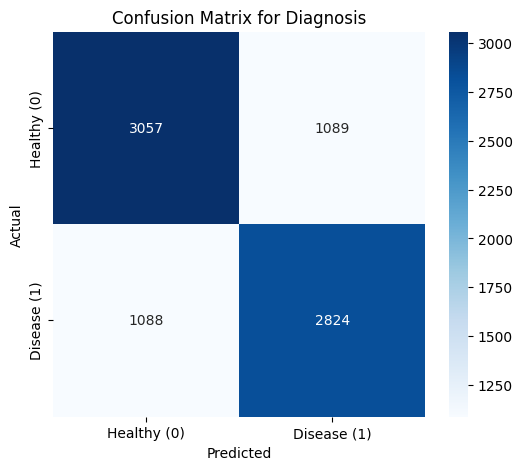

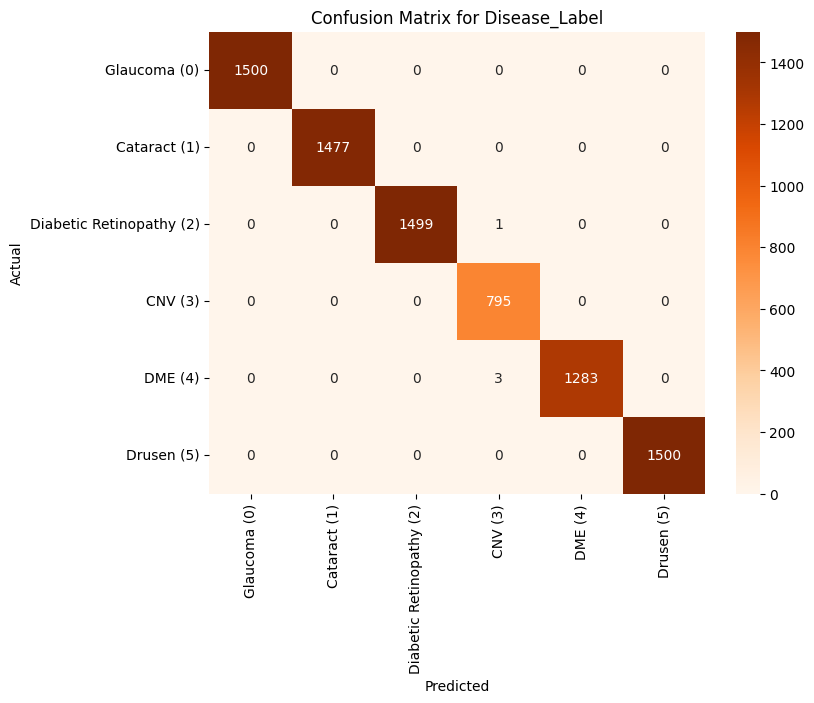

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -----------------------------------------
# 🔹 Confusion Matrix for Diagnosis (Binary Classification)
# -----------------------------------------

# Compute confusion matrix
conf_matrix_diagnosis = confusion_matrix(y_test["Diagnosis"], y_test_pred_diagnosis)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_diagnosis, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy (0)", "Disease (1)"],
            yticklabels=["Healthy (0)", "Disease (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Diagnosis")
plt.show()

# -----------------------------------------
# 🔹 Confusion Matrix for Disease_Label (Multi-Class Classification)
# -----------------------------------------

# Compute confusion matrix
conf_matrix_disease = confusion_matrix(y_test["Disease_Label"], y_test_pred_disease)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_disease, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Glaucoma (0)", "Cataract (1)", "Diabetic Retinopathy (2)",
                         "CNV (3)", "DME (4)", "Drusen (5)"],
            yticklabels=["Glaucoma (0)", "Cataract (1)", "Diabetic Retinopathy (2)",
                         "CNV (3)", "DME (4)", "Drusen (5)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Disease_Label")
plt.show()
